In [2]:
import pandas as pd
import nltk
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import time
import warnings
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from transformers import BertForSequenceClassification ,BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer
from sklearn.metrics import f1_score


from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dhane\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dhane\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\dhane\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\dhane\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
C:\software\python\python3114\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
pip install torchinfo


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: C:\software\python\python3114\python.exe -m pip install --upgrade pip


In [3]:
#drive.mount('/content/drive/')
data = pd.read_csv("./yelp_review_train.csv")
test_data = pd.read_csv("./yelp_review_test.csv")

In [13]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


On looking at the data , we just have text and stars which the rating for the said review

In [14]:
data.head()

,text,stars
0,Went for lunch and found that my burger was me...,2.0
1,I needed a new tires for my wife's car. They h...,5.0
2,Jim Woltman who works at Goleta Honda is 5 sta...,5.0
3,Been here a few times to get some shrimp. The...,4.0
4,This is one fantastic place to eat whether you...,5.0


In [15]:
data.isnull().sum(axis = 0)

text     0
stars    0
dtype: int64

In [16]:
classes, counts = np.unique(data['stars'].to_numpy(),return_counts = True)

In [17]:
print('labesls : ',classes)
print('counts : ', counts)

labesls :  [1. 2. 3. 4. 5.]
counts :  [26821 13524 17235 36391 80786]


<Axes: title={'center': 'star rating vs review count'}, xlabel='star ratings', ylabel='review count'>

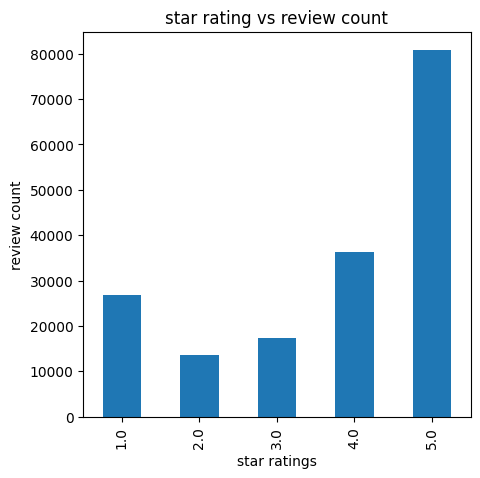

In [18]:
data['stars'].value_counts().sort_index().plot(kind = 'bar',figsize = (5,5), xlabel = 'star ratings',ylabel = 'review count',title = 'star rating vs review count')

Rating: 1.0 stars


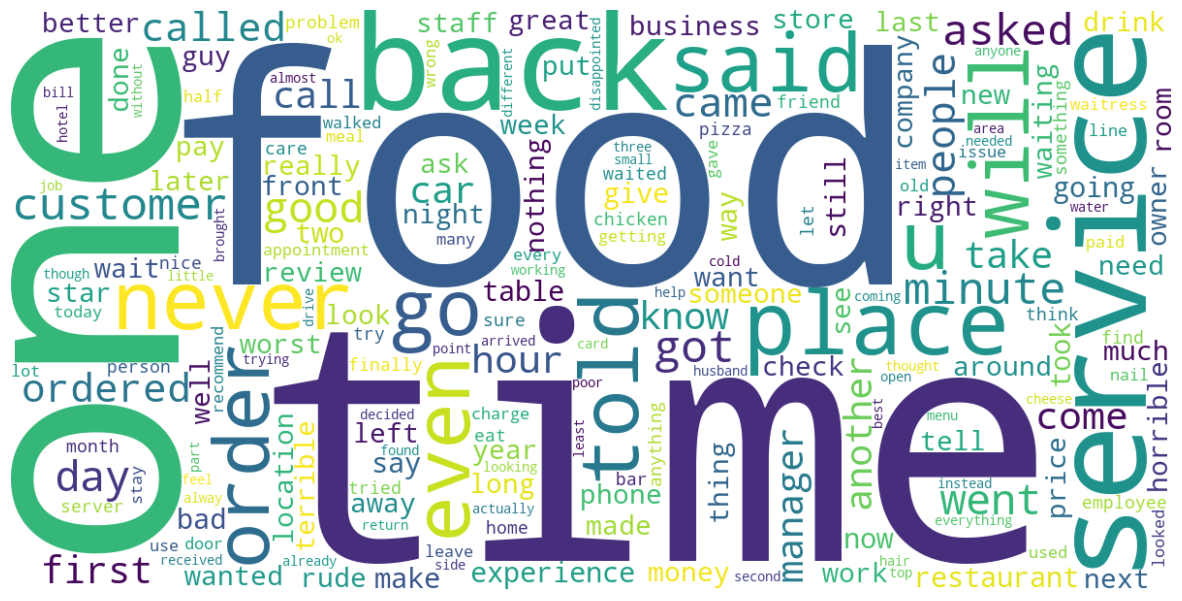

*************************
Rating: 2.0 stars


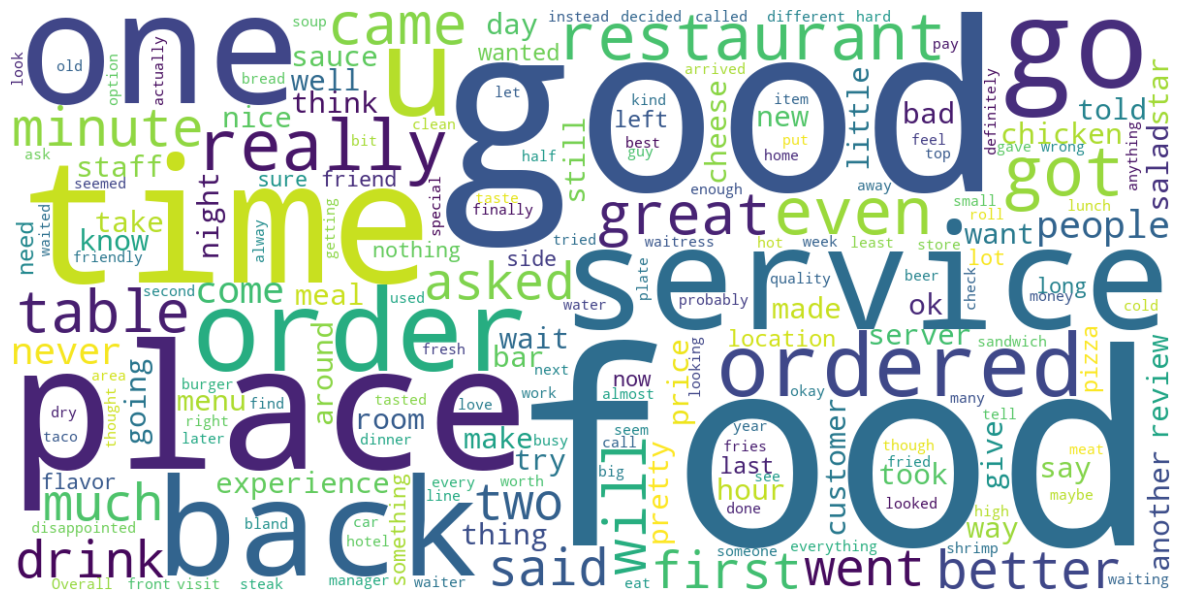

*************************
Rating: 3.0 stars


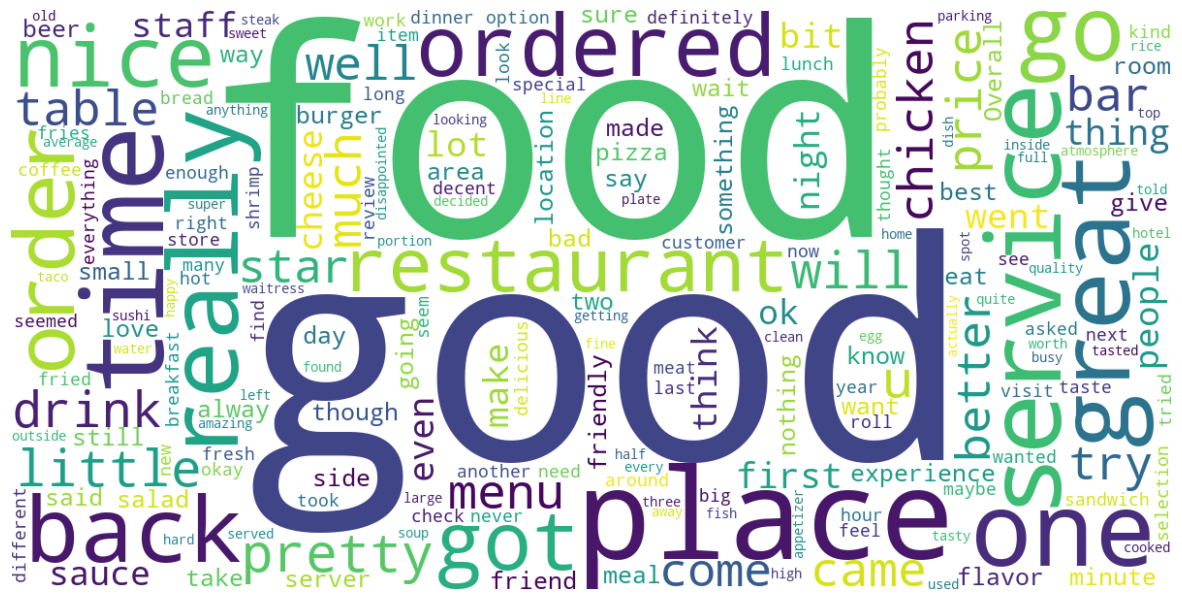

*************************
Rating: 4.0 stars


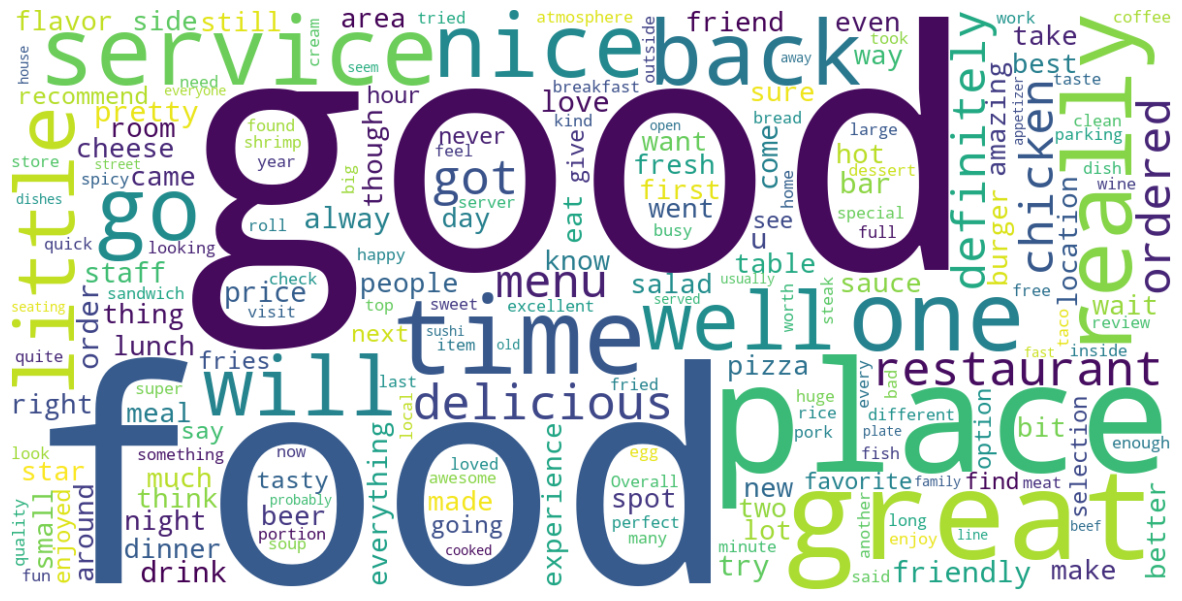

*************************
Rating: 5.0 stars


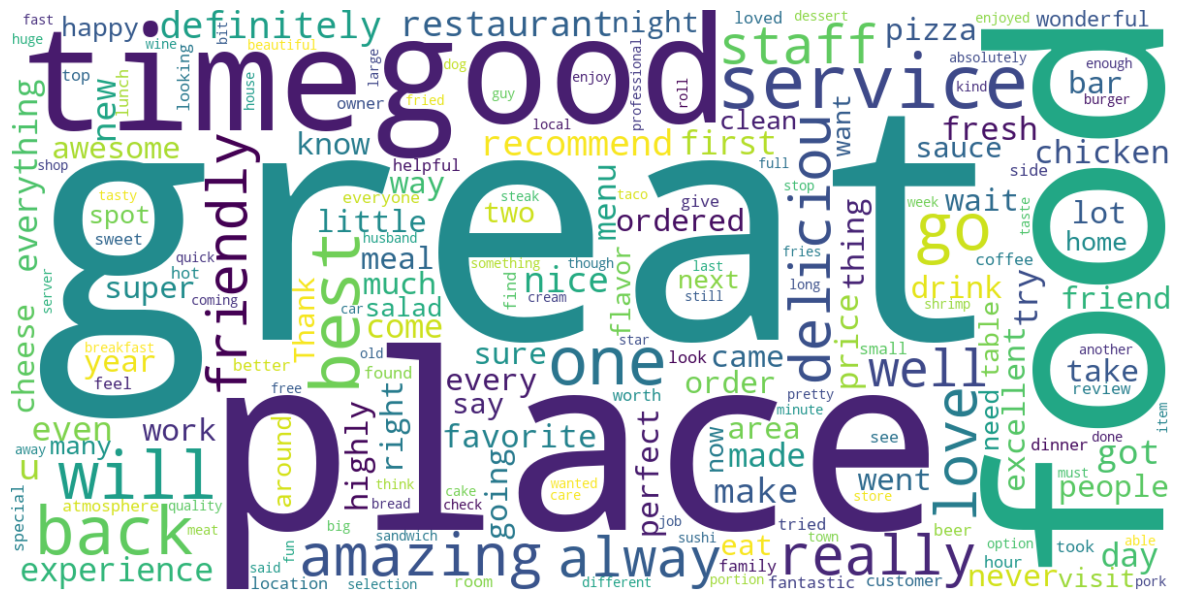

*************************


In [19]:
for rating in sorted(data['stars'].unique()):
    print(f'Rating: {rating} stars')


    text = ' '.join(review for review in data[data['stars'] == rating]['text'].values)

    # WordCloud uses a built-in stopwords list
    wordcloud = WordCloud(collocations=False, background_color='white', width=1200, height=600).generate(text)

    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    print('*' * 25)

C:\software\python\python3114\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x1500 with 0 Axes>

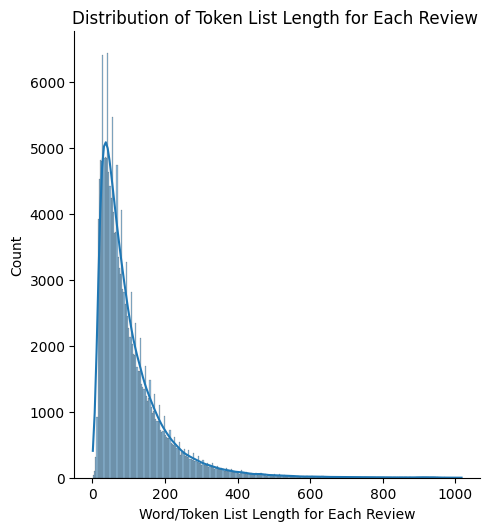

In [5]:
plt.figure(figsize=(20,15))
sns.displot([len(txt.split()) for txt in data['text'].values],kde = True)
plt.title('Distribution of Token List Length for Each Review ')
plt.xlabel('Word/Token List Length for Each Review')
plt.show()

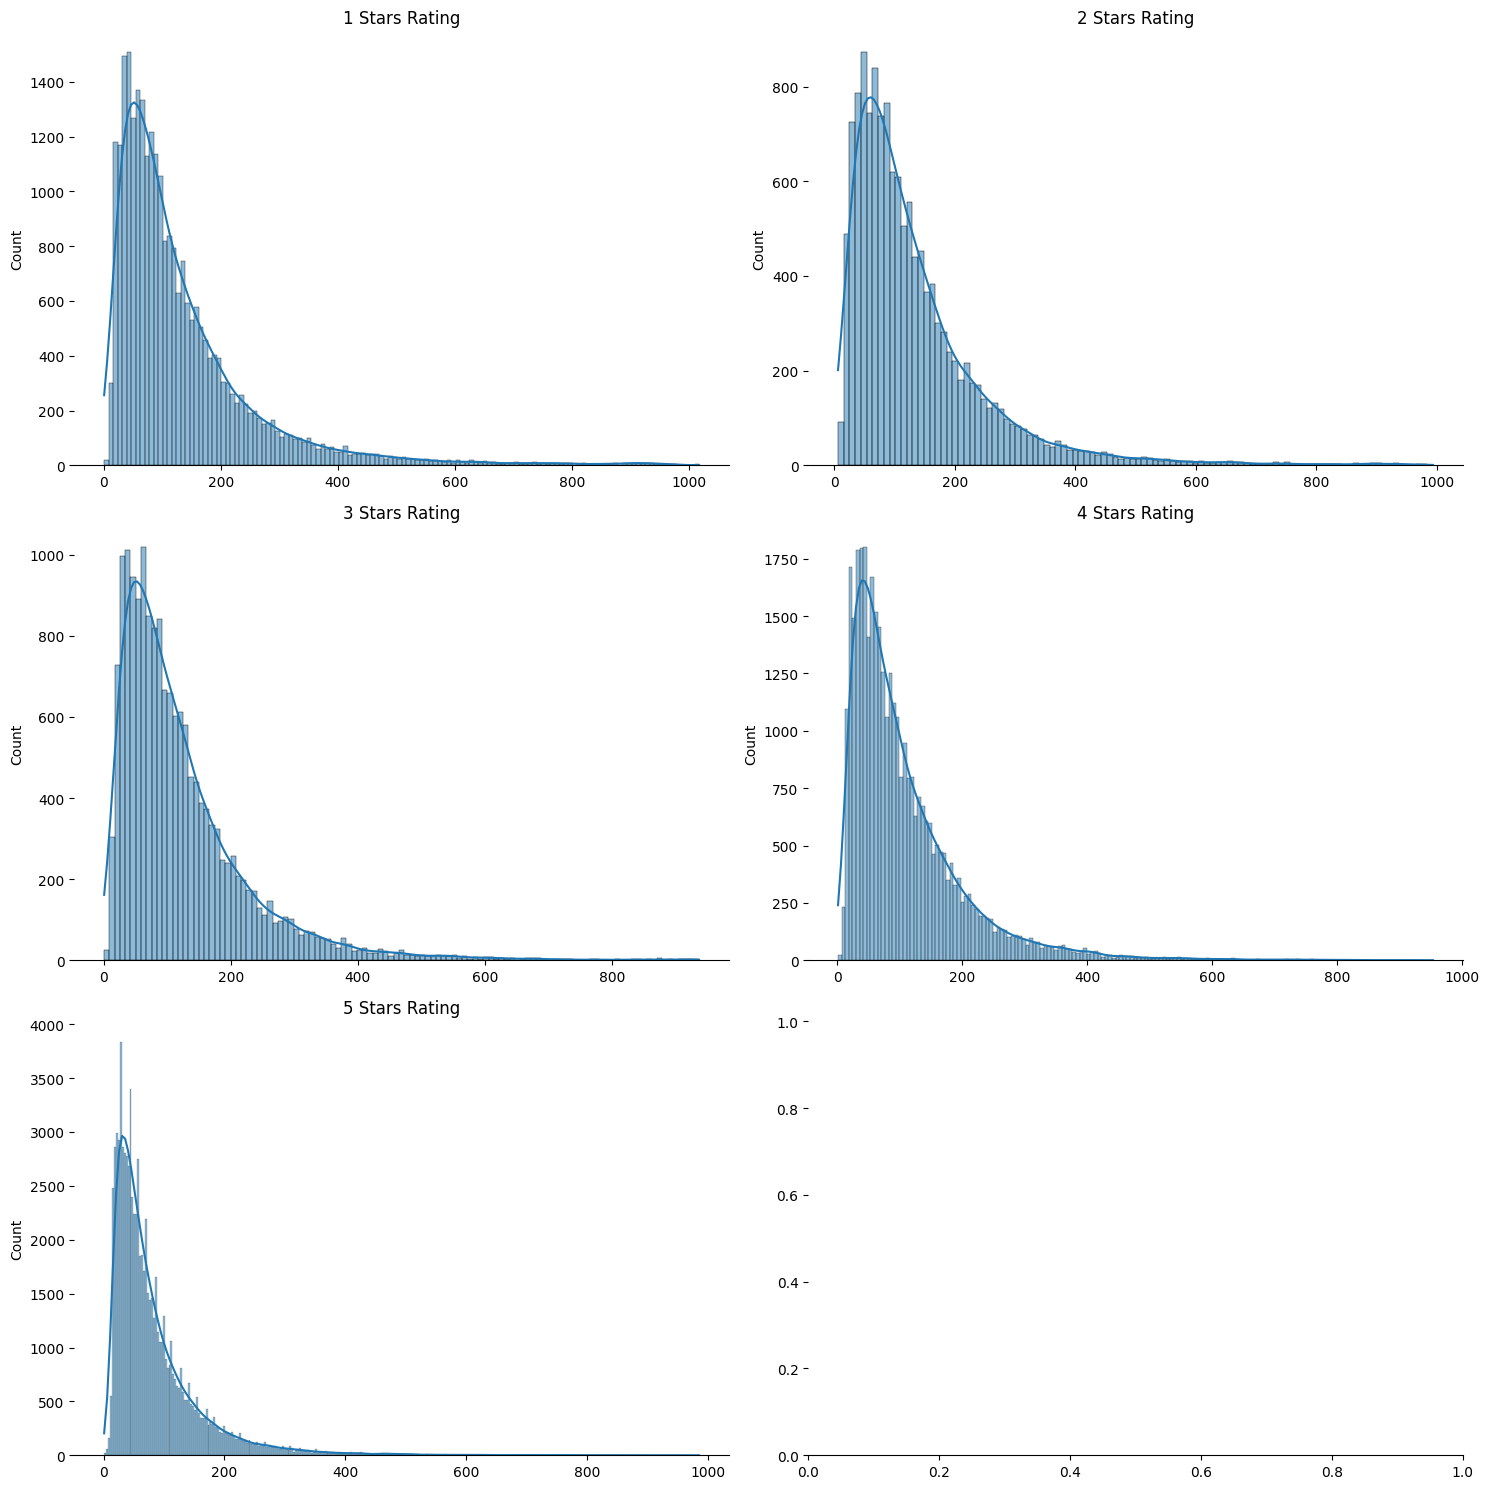

In [21]:
f, axes = plt.subplots(3, 2, figsize=(15,15), sharex=False)
sns.despine(left=True)

#
plot_y = 0
for idx, stars in enumerate([1, 2, 3, 4, 5]):
    plot_x = 0 if idx % 2 == 0 else 1


    sns.histplot(
        [len(txt.split()) for txt in data[data['stars'] == stars]['text'].values],
        kde = True,ax = axes[plot_y, plot_x] )
    axes[plot_y, plot_x].set_title(f'{stars} Stars Rating')
    plot_y += 1 if idx % 2 == 1 else 0

plt.tight_layout()
plt.show()

**Preprocessing Data**

In [6]:
X = data['text']
y = data['stars']
seed = 21
TRAINED_MODEL_NAME = "bert-base-cased"

NameError: name 'data' is not defined

In [7]:
TRAINED_MODEL_NAME = "bert-base-cased"

In [23]:
x_train, x_val , y_train, y_val = train_test_split(X,y,train_size= 0.80,random_state= seed)


In [8]:
tokenizer = BertTokenizer.from_pretrained(TRAINED_MODEL_NAME)

In [9]:
from tqdm import tqdm
token_lens = []
for txt in tqdm(data.text):
  tokens = tokenizer.encode(txt, max_length=512, truncation= True)
  token_lens.append(len(tokens))



100%|████████████████████████████████████████████████████████████████████████| 174757/174757 [02:18<00:00, 1264.40it/s]


C:\software\python\python3114\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


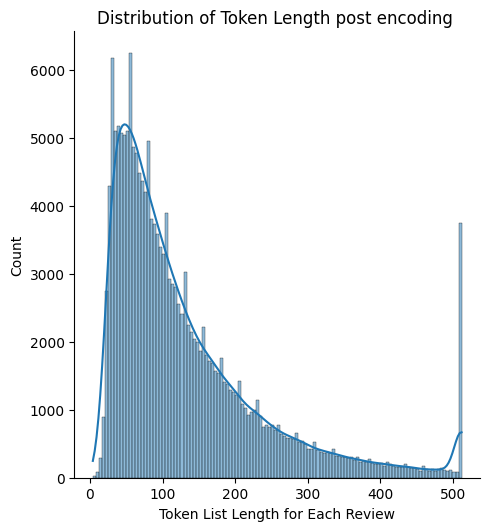

In [10]:
sns.displot(token_lens,kde = True)
plt.title('Distribution of Token Length post encoding ')
plt.xlabel('Token List Length for Each Review')
plt.show()

In [27]:
MAX_LEN = 120

In [28]:
from torch.utils.data import Dataset, DataLoader
class TokenizeDataset(Dataset):
    def __init__(self,txt,targets,tokenizer,max_len):
        self.reviews = txt
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation = True,
            return_attention_mask=True,
            return_tensors='pt',
            )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

In [29]:
def discriminator(x) :
  if x > 3:
    return 2
  elif x == 3:
    return 1
  else:
    return 0

In [4]:
class_names = ['negative','neutral','positive']

In [31]:
from sklearn.utils.class_weight import compute_class_weight
class_weights_train = list(map(lambda x: discriminator(x), y_train))
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(class_weights_train), y= class_weights_train)
print(class_weights)
print(np.unique(class_weights_train,return_counts= True))

[1.44313349 3.36134353 0.49762055]
(array([0, 1, 2]), array([32292, 13864, 93649], dtype=int64))


In [32]:
class_weights_dataset = list(map(lambda x: discriminator(x), y))
class_weights_set = compute_class_weight(class_weight = "balanced", classes= np.unique(class_weights_dataset), y= class_weights_dataset)
print(class_weights_set)
print(np.unique(class_weights_dataset,return_counts= True))

[1.44385508 3.37988589 0.49713112]
(array([0, 1, 2]), array([ 40345,  17235, 117177], dtype=int64))


In [33]:

def create_data_loader(x,y,tokenizer,max_len,batch_size):
    ds = TokenizeDataset(
        txt = x.to_numpy(),
        targets = np.array(y),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=2)

In [34]:
y_train =list(map(lambda x: discriminator(x), y_train))
y_val = list(map(lambda x: discriminator(x), y_val))

In [35]:
y_test = list(map(lambda x: discriminator(x), test_data['stars']))
x_test = test_data['text']

In [36]:
np.unique(y_train,return_counts= True)
print(x_test.shape)

(13980,)


In [37]:

BATCH_SIZE = 32
train_data_loader = create_data_loader(x_train,y_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(x_val, y_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(x_test,y_test, tokenizer, MAX_LEN, BATCH_SIZE)


**Transformer Model**

In [38]:

# Define the device (GPU or CPU) to train the model on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if device.type == 'cuda':
#     model.cuda()
#     print(f'{torch.cuda.get_device_name(0)} is used...')
# else:
#     print('CPU is used...')

In [38]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict = False
    )
    #print(pooled_output)
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return self.out(output)

In [ ]:
pip install google-colab

In [40]:
classifier = SentimentClassifier(len(class_names))
classifier = classifier.to(device)

NameError: name 'device' is not defined

In [59]:
print(classifier.config)
#print(sum(p.numel() for p in classifier.parameters()))

AttributeError: 'SentimentClassifier' object has no attribute 'cofig'

In [52]:

summary(classifier,input_size=(768,),depth=1,batch_dim=1, dtypes=['torch.IntTensor'])

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [45]:
print(BertModel.from_pretrained(TRAINED_MODEL_NAME))

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [42]:
EPOCHS = 4
optimizer = AdamW(classifier.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)


loss_fn = nn.CrossEntropyLoss().to(device)


C:\software\python\python3114\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [43]:
def _format_elapsed_time(elapsed):
    """
    Convert elapsed time from seconds to hh:mm:ss.s format.

    :param elapsed: float
        Elapsed time in seconds (t_current - t_start).
    :return: string
        Time in human-readable hh:mm:ss.s format, e.g. '04:35:41.05'.
    """

    hours, remainder = divmod(elapsed, 60*60)
    minutes, seconds = divmod(remainder, 60)

    return "{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds)

In [44]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    step = 0
    t_start = time.time()

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)
        # Print out the progress every 25 steps
        if (step + 1) % 25 == 0 and step != 0:
            elapsed_time = TransformersGeneric._format_elapsed_time(time.time() - t_start)
            print(f'\tBatch {step + 1}/{len(train_data_loader)}, elapsed {elapsed_time}')

        step += 1
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [45]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [36]:
len(x_train)

139805

In [ ]:

from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        classifier,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(x_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        classifier,
        val_data_loader,
        loss_fn,
        device,
        len(x_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(classifier.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/4
----------
